In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

import seaborn as sns
from matplotlib import  pyplot as plt
%matplotlib inline

/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [2]:
#reading the data
folder = '/kaggle/input/m5-forecasting-accuracy/'
calendar = pd.read_csv(folder+'calendar.csv')
sell_prices = pd.read_csv(folder+'sell_prices.csv')
stv = pd.read_csv(folder+'sales_train_validation.csv')

In [3]:
calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [5]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
print(
'''
Total amount of id: {5}
Unique:
item_id: {0}
dept_id: {1}
cat_id:  {2}
store_id:{3}
state_id:{4}
'''.format(
    stv.item_id.nunique(),
    stv.dept_id.nunique(),
    stv.cat_id.nunique(),
    stv.store_id.nunique(),
    stv.state_id.nunique(),
    len(stv)
)
)


Total amount of id: 30490
Unique:
item_id: 3049
dept_id: 7
cat_id:  3
store_id:10
state_id:3



In [7]:
sell_prices.head().T

,0,1,2,3,4
store_id,CA_1,CA_1,CA_1,CA_1,CA_1
item_id,HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1_001
wm_yr_wk,11325,11326,11327,11328,11329
sell_price,9.58,9.58,8.26,8.26,8.26


In [8]:
cat_col = ['item_id','dept_id','cat_id','store_id','state_id']
index_col = cat_col+['id']

In [9]:
le = LabelEncoder()
for i in cat_col: 
    stv[i+'_label'] = le.fit_transform(stv[i])


### train, validation and evaluation preparing

In [10]:
#train
indx_col_label =['id','item_id_label','dept_id_label','cat_id_label','store_id_label',
             'state_id_label']
X = pd.DataFrame(
    columns=['id','item_id_label','dept_id_label','cat_id_label','store_id_label',
             'state_id_label','day','target'])

learning_days = 84
period = 28
for day in range(1914-learning_days,1914):
    #print(day)
    cols_to = ['target']
    cols_from = ['d_'+str(day)]
    for i in range(1,4):
            #print(i)
        if day>=i*period:
            cols_from.append('d_'+str(day-period*i))
            cols_to.append('prev'+str(i)) 
    cols_to+=indx_col_label
    cols_from+=indx_col_label
    tmp = stv.loc[:,cols_from]
    tmp.columns = cols_to
    tmp.loc[:,'day'] = day
    
    X = X.append(tmp)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Feature engineering

In [11]:
X.head()

,cat_id_label,day,dept_id_label,id,item_id_label,prev1,prev2,prev3,state_id_label,store_id_label,target
0,1,1830,3,HOBBIES_1_001_CA_1_validation,1437,2.0,1.0,1.0,0,0,1
1,1,1830,3,HOBBIES_1_002_CA_1_validation,1438,0.0,0.0,1.0,0,0,1
2,1,1830,3,HOBBIES_1_003_CA_1_validation,1439,0.0,2.0,0.0,0,0,0
3,1,1830,3,HOBBIES_1_004_CA_1_validation,1440,0.0,0.0,0.0,0,0,1
4,1,1830,3,HOBBIES_1_005_CA_1_validation,1441,0.0,1.0,2.0,0,0,0


In [12]:
X[X.target>=170]

,cat_id_label,day,dept_id_label,id,item_id_label,prev1,prev2,prev3,state_id_label,store_id_label,target
26850,0,1835,2,FOODS_3_234_WI_2_validation,846,172.0,3.0,0.0,2,8,173
8412,0,1842,2,FOODS_3_090_CA_3_validation,702,117.0,0.0,140.0,0,2,177
29755,0,1843,2,FOODS_3_090_WI_3_validation,702,96.0,0.0,84.0,2,9,174
26850,0,1844,2,FOODS_3_234_WI_2_validation,846,145.0,45.0,0.0,2,8,171
8412,0,1856,2,FOODS_3_090_CA_3_validation,702,113.0,0.0,2.0,0,2,170
26578,0,1863,1,FOODS_2_360_WI_2_validation,574,0.0,0.0,0.0,2,8,248
26578,0,1864,1,FOODS_2_360_WI_2_validation,574,0.0,0.0,0.0,2,8,174
8412,0,1877,2,FOODS_3_090_CA_3_validation,702,145.0,144.0,6.0,0,2,182
8412,0,1884,2,FOODS_3_090_CA_3_validation,702,170.0,113.0,0.0,0,2,218
8412,0,1885,2,FOODS_3_090_CA_3_validation,702,122.0,98.0,0.0,0,2,212


In [13]:
ftr = [ 'item_id_label', 'dept_id_label', 'cat_id_label', 'store_id_label', 'state_id_label','day','prev1','prev2','prev3']

In [14]:
for i in ftr:
    X[i] = X[i].astype(int)
X['target'] = X['target'].astype(int)

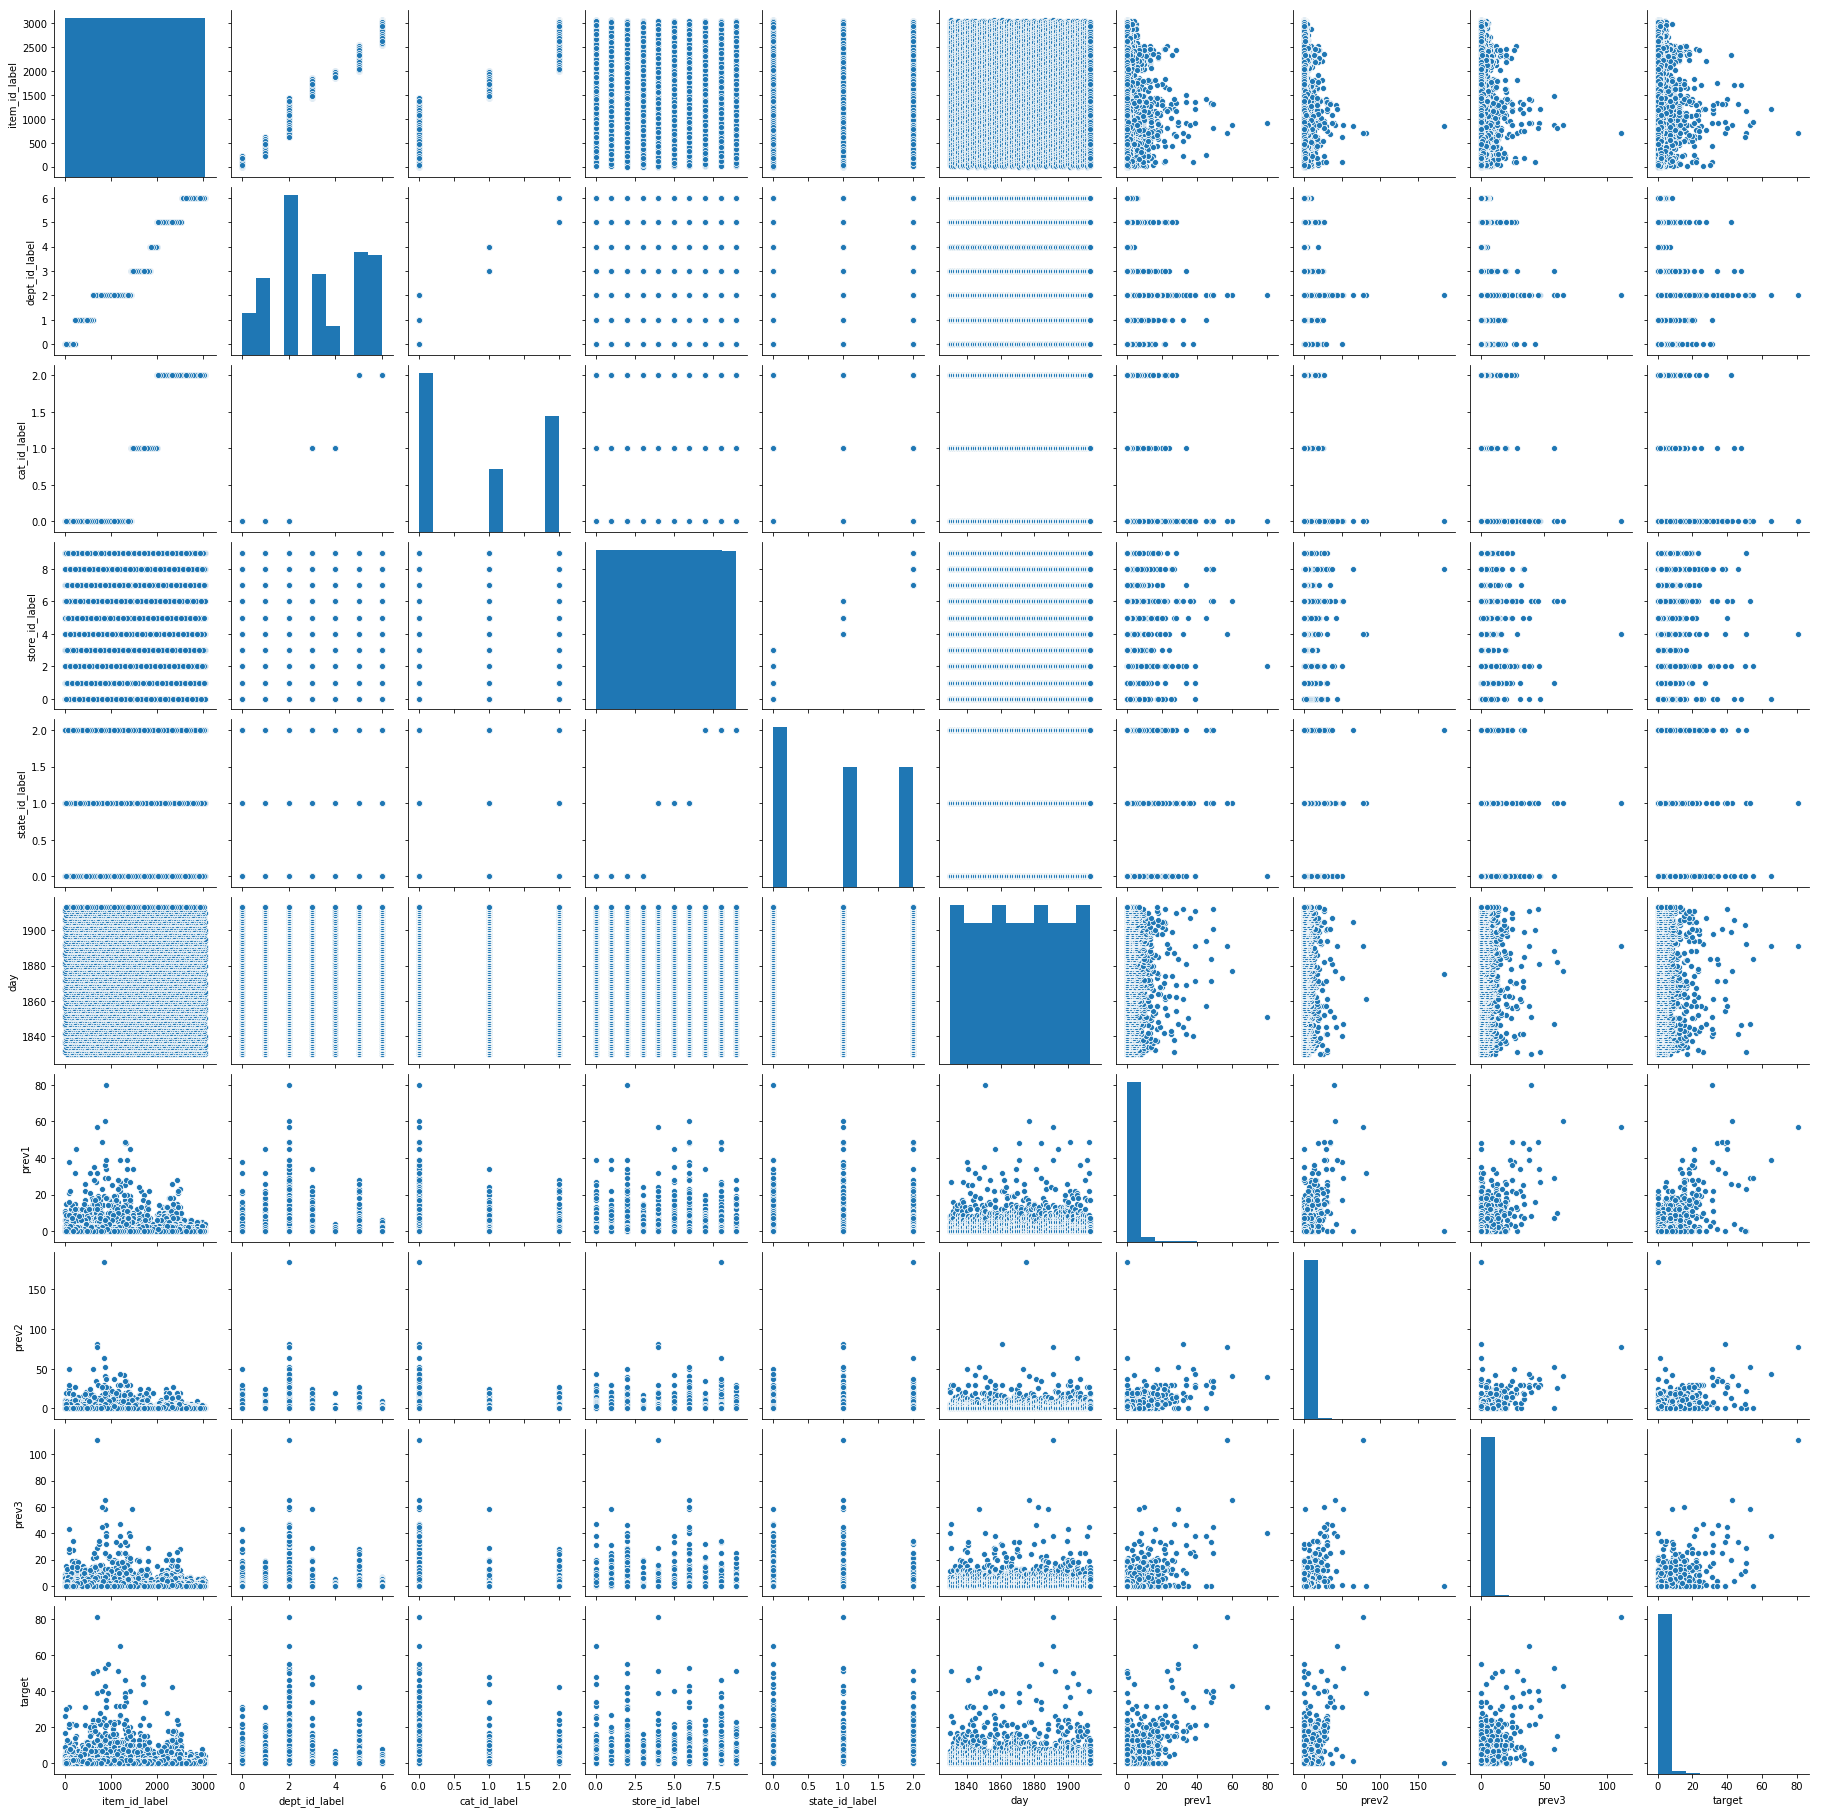

In [15]:
sns.pairplot(X[ftr+['target']][::300])

In [16]:
X[X.target>=100].item_id_label.value_counts()

702     96
1198    31
682      8
574      8
732      8
1110     6
846      4
1024     3
1293     3
894      2
620      2
864      2
1322     1
342      1
1663     1
1159     1
1192     1
893      1
Name: item_id_label, dtype: int64

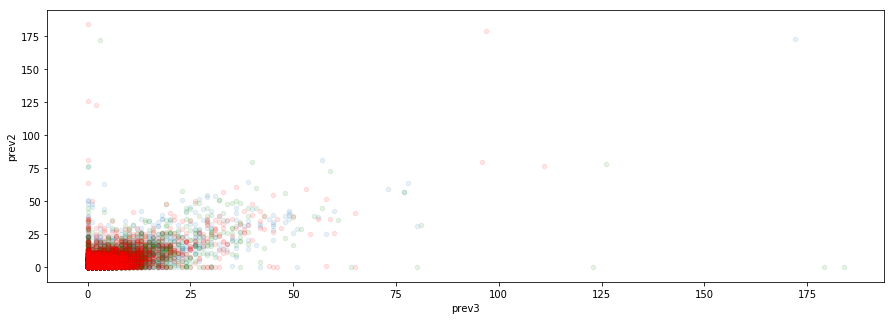

In [17]:
fig, ax = plt.subplots(1,1,figsize = (15,5))
X[::100].plot.scatter(x = 'prev1',y = 'target',ax = ax,alpha = .1)
X[::100].plot.scatter(x = 'prev2',y = 'prev1',ax = ax,alpha = .1, color = 'g')
X[::100].plot.scatter(x = 'prev3',y = 'prev2',ax = ax,alpha = .1, color = 'r')


In [18]:
X['prev1'] = X['prev1'].clip(0,75)
X['prev2'] = X['prev2'].clip(0,75)
X['prev3'] = X['prev3'].clip(0,75)
X['target'] = X['target'].clip(0,75)

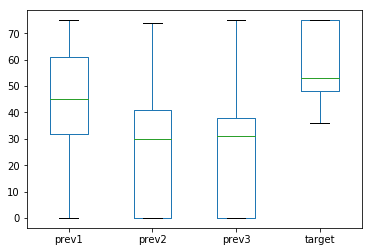

In [19]:
X[X.item_id_label.isin([702,1198])][::100][['prev1','prev2','prev3','target']].plot.box()

# Model fitting

In [20]:
lgbm = LGBMRegressor(max_depth = 7, objective='rmse')

# Validation

In [21]:
split_points = [X.day.min(),int(X.day.mean()),X.day.max()] 

In [22]:
split_points

[1830, 1871, 1913]

In [23]:
X_train = X[(X.day>=split_points[0])&(X.day<split_points[1])][ftr]
X_test = X[(X.day>=split_points[1])&(X.day<split_points[2])][ftr]
y_train = X[(X.day>=split_points[0])&(X.day<split_points[1])][['target']]
y_test = X[(X.day>=split_points[1])&(X.day<split_points[2])][['target']]

In [24]:
lgbm.fit(X_train,y_train.target)
val_pred = lgbm.predict(X_test)


In [25]:
y_train.loc[:,'prev'] = y_train.target.shift(1)

In [26]:
(mean_squared_error(val_pred,y_test.target)/mean_squared_error(y_train[1:]['target'],y_train[1:]['prev']))**0.5

0.4874145106367715

In [27]:
(mean_squared_error(y_test,val_pred))**0.5

2.3296074676624823

# Prediction and submission

In [28]:
#validation
test = pd.DataFrame(columns=['id','item_id_label','dept_id_label','cat_id_label','store_id_label',
             'state_id_label','day','prev1','prev2','prev3'])
for day in range(1914,1942):
    #tmp = stv.loc[:,indx_col_label]
    tmp = X[X.day==day-28].loc[:,indx_col_label+['target','prev1','prev2']]
    tmp.rename(columns = {'target':'prev1','prev1':'prev2','prev2':'prev3'})
    tmp.loc[:,'day'] = day

    test = test.append(tmp)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [29]:
lgbm.fit(X[ftr],X['target'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective='rmse',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
test = test.fillna(0)
for i in ftr:
    test[i] = test[i].astype(int)


In [31]:
pred = lgbm.predict(test[ftr])


In [32]:
res = test[['id','day']]
res['target'] = pred
base = 1914
r = stv[['id']]



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
for i in range(base,base+28):
    col = 'F'+str(i-base+1)
    r = r.merge(res[res.day==i][['id','target']], on = 'id',how = 'left')
    r = r.rename(columns = {'target':col})

In [34]:
X.head()

,cat_id_label,day,dept_id_label,id,item_id_label,prev1,prev2,prev3,state_id_label,store_id_label,target
0,1,1830,3,HOBBIES_1_001_CA_1_validation,1437,2,1,1,0,0,1
1,1,1830,3,HOBBIES_1_002_CA_1_validation,1438,0,0,1,0,0,1
2,1,1830,3,HOBBIES_1_003_CA_1_validation,1439,0,2,0,0,0,0
3,1,1830,3,HOBBIES_1_004_CA_1_validation,1440,0,0,0,0,0,1
4,1,1830,3,HOBBIES_1_005_CA_1_validation,1441,0,1,2,0,0,0


In [35]:
#evaluation
evaluation = pd.DataFrame(columns=['id','item_id_label','dept_id_label','cat_id_label','store_id_label',
             'state_id_label','day','prev1','prev2','prev3'])
for day in range(1942,1970):
    tmp = X[X.day==day-56].loc[:,indx_col_label+['prev1','prev2']]
    tmp.rename(columns = {'prev1':'prev2','prev2':'prev3'})
    tmp.loc[:,'prev1'] = res[res.day==day]['target']
    tmp.loc[:,'day'] = day

    test = test.append(tmp)
    evaluation = evaluation.append(tmp)



In [36]:
evaluation = evaluation.fillna(0)
for i in ftr:
    evaluation[i] = evaluation[i].astype(int)

In [37]:
evaluation['id'] = evaluation['id'].apply(lambda x: x.replace('validation','evaluation'))

In [38]:
pred_ev = lgbm.predict(evaluation[ftr])

In [39]:
evaluation.head()

,cat_id_label,day,dept_id_label,id,item_id_label,prev1,prev2,prev3,state_id_label,store_id_label
0,1,1942,3,HOBBIES_1_001_CA_1_evaluation,1437,0,1,0,0,0
1,1,1942,3,HOBBIES_1_002_CA_1_evaluation,1438,0,1,0,0,0
2,1,1942,3,HOBBIES_1_003_CA_1_evaluation,1439,0,0,0,0,0
3,1,1942,3,HOBBIES_1_004_CA_1_evaluation,1440,0,1,0,0,0
4,1,1942,3,HOBBIES_1_005_CA_1_evaluation,1441,0,0,0,0,0


In [40]:
base = 1942
evaluation['target']=pred_ev
r2 = pd.DataFrame(columns = ['id'])
r2['id'] =stv['item_id']+'_'+stv['store_id']+'_'+'evaluation'
for i in range(base,base+28):
    col = 'F'+str(i-base+1)
    r2 = r2.merge(evaluation[evaluation.day==i][['id','target']], on = 'id',how = 'left')
    r2 = r2.rename(columns = {'target':col})

In [41]:
r.append(r2).to_csv('submission.csv',index = False)